In [2]:

# IRT Fault Detection Using Transfer Learning with VGG-16

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pandas as pd
import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import io

In [3]:
# --- Setup ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

In [5]:
# --- Organize Dataset ---
original_data_dir = '/Users/reamy/Desktop/THESIS/solar'  # Contains 'faulty/' and 'non_faulty/' folders
base_dir = 'data/processed'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Create directories
for split in ['train', 'val']:
    for cls in ['faulty', 'non-faulty']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Split and copy images
for cls in ['faulty', 'non-faulty']:
    cls_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_dir)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in val_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))

In [6]:
# --- Data Augmentation and Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 182 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [7]:
# --- Get True Labels for Callback ---
val_labels = np.concatenate([val_generator[i][1] for i in range(len(val_generator))])

# --- Load VGG16 base model (without top) ---
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# --- Add custom classification head ---
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
# --- Compile Model ---
model.compile(
    optimizer='adamW',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
model.summary()

# Save model summary to file
summary_file_path = os.path.join(os.getcwd(), 'vgg16_model_summary.txt')
with io.StringIO() as buf:
    model.summary(print_fn=lambda x: buf.write(x + '\n'))
    summary_text = buf.getvalue()

with open(summary_file_path, 'w') as f:
    f.write(summary_text)

print(f"Model summary saved to {summary_file_path}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Model summary saved to /Users/reamy/Desktop/THESIS/VGG-16/vgg16_model_summary.txt


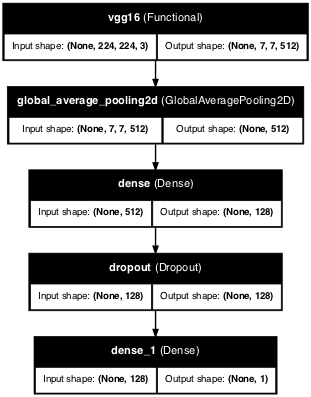

In [10]:
# Save the architecture as an image file in the current working directory
output_path = os.path.join(os.getcwd(), 'vgg16_model_architecture.png')
plot_model(model, to_file=output_path, show_shapes=True, show_layer_names=True, dpi=50)

# Display the architecture in the notebook
Image(filename=output_path)

In [11]:
# --- Custom Callback to Track Metrics ---
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, val_labels):
        self.val_generator = val_generator
        self.val_labels = val_labels.reshape(-1).astype(int)
        self.results = []

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = model.predict(self.val_generator)
        val_predictions = (val_predictions > 0.5).astype(int).reshape(-1)

        precision = precision_score(self.val_labels, val_predictions)
        recall = recall_score(self.val_labels, val_predictions)
        f1 = f1_score(self.val_labels, val_predictions)

        self.results.append({
            'Epoch': epoch + 1,
            'Training Accuracy': logs['accuracy'],
            'Validation Accuracy': logs['val_accuracy'],
            'Training Loss': logs['loss'],
            'Validation Loss': logs['val_loss'],
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        print(f"Epoch {epoch + 1}: Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

metrics_callback = MetricsCallback(val_generator, val_labels)

In [12]:

# --- Train the Model ---
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[metrics_callback]
)


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5097 - auc_1: 0.5311 - loss: 0.7366 - precision_1: 0.4958 - recall_1: 0.41
Epoch 1: Precision=0.6111, Recall=0.9565, F1 Score=0.7458
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.5099 - auc_1: 0.5329 - loss: 0.7360 - precision_1: 0.4979 - recall_1: 0.4300 - val_accuracy: 0.6739 - val_auc_1: 0.8365 - val_loss: 0.6726 - val_precision_1: 0.6111 - val_recall_1: 0.9565
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5040 - auc_1: 0.5220 - loss: 0.7297 - precision_1: 0.4887 - recall_1: 0.53
Epoch 2: Precision=0.9167, Recall=0.4783, F1 Score=0.6286
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.5113 - auc_1: 0.5256 - loss: 0.7266 - precision_1: 0.4988 - recall_1: 0.5291 - val_accuracy: 0.7174 - val_auc_1: 0.8875 - val_loss: 0.6612 - val_precision_1: 0.9167 - val_recall_1: 0.4783
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5622 - auc_1: 0.6271 - loss: 0.6680 - precision_1: 0.5694 - recall_1: 0.5

In [13]:
# --- Save Metrics to CSV ---
results_df = pd.DataFrame(metrics_callback.results)
results_file_path = os.path.join(os.getcwd(), 'training_results_vgg16.csv')
results_df.to_csv(results_file_path, index=False)
print(f"Training results saved to {results_file_path}")

Training results saved to /Users/reamy/Desktop/THESIS/VGG-16/training_results_vgg16.csv


In [14]:
# --- Plotting Metrics ---
metrics = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
titles = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
file_names = ['vgg16_precision.png', 'vgg16_recall.png', 'vgg16_f1.png',
              'vgg16_train_acc.png', 'vgg16_val_acc.png', 'vgg16_train_loss.png', 'vgg16_val_loss.png']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    plt.plot(results_df[metric], label=metric, linewidth=2, color='green', marker='o')
    plt.title(titles[i], fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    # Annotate last value
    last_epoch = len(results_df[metric]) - 1
    last_value = results_df[metric].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + 0.02),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

    plt.tight_layout()
    plt.savefig(file_names[i], dpi=300)
    plt.close()

print("All VGG16 transfer learning plots saved successfully.")

All VGG16 transfer learning plots saved successfully.


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


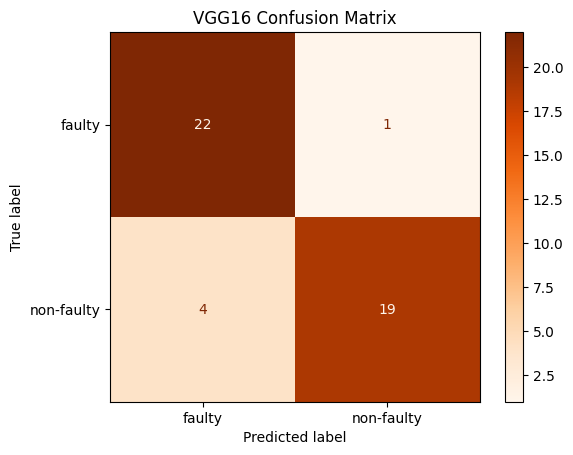

In [15]:
# --- Confusion Matrix ---
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int).reshape(-1)
cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Oranges)
plt.title("VGG16 Confusion Matrix")
plt.savefig("vgg16_confusion_matrix.png", dpi=300)
plt.show()

In [16]:
model.save('VGG-16_BC_model.h5')  # Save the trained model